In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# What is a digital image?

An **image** is a 2D array of **intensity** values. Since each **pixel** in an image has an **(x,y)** coordinate, an image can also be thought of as a **function** of **(x,y)**. That is,

$
F(x, y) = \text{image}
$

Below, you see the flat image, and its depiction as a function of two variables.
<img src="images/flat_image.png" title="Flat Image" alt="Drawing" style="width: 200px;"/>
<img src="images/image_as_function.png" alt="Drawing" style="width: 200px;"/>

If the function is smoothened, the image becomes blurred.
<img src="images/smoothened_function.png" alt="Drawing" style="width: 400px;"/>

An RGB image, that is, an image with three color channels, is a vector of 3 functions.

$
f(x,y) =
\begin{bmatrix}
r(x,y) \\
g(x,y) \\
b(x,y) \\
\end{bmatrix}
\quad
\begin{array}{l}
\text{red channel} \\
\text{green channel} \\
\text{blue channel} \\
\end{array}
$

# Blackening out non-white pixels 

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


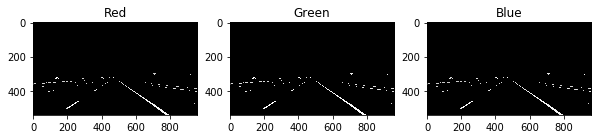

In [25]:
# Read in the image and print out some stats
image = mpimg.imread('test.jpg')
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

# Define our color selection criteria
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the R, G, and B channels of the image separately
plt.subplot(1,3,1)
plt.title("Red")
plt.imshow(color_select[:,:,0])

plt.subplot(1,3,2)
plt.title("Green")
plt.imshow(color_select[:,:,1])

plt.subplot(1,3,3)
plt.title("Blue")
plt.imshow(color_select[:,:,2])
plt.show()

All pixels that meet the color criterion (those above the threshold) will be retained, and those that do not (below the threshold) will be blacked out. Use a divide and conquer strategy to find a value between 0 and 255 that produces lanes. Eventually, you'll find that 200 does fairly well.

# Triangular mask over pixels that matter
If you assume the front facing camera is always mounted in a fixed position on the car such that the lane lines appear in the same general region, you can overlay a triangular mask and only retain those pixels in the region.

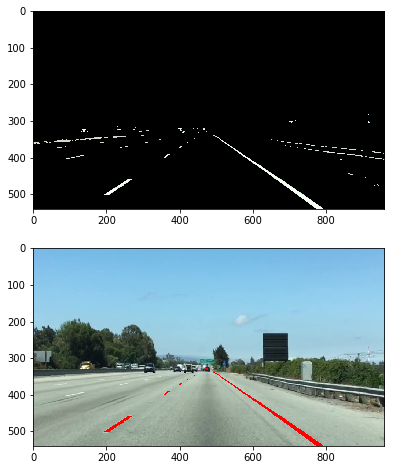

In [46]:
# Read in the image
image = mpimg.imread('test.jpg')

# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest (Note: if you run this code, 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz ;)
# Based on the shape of the image, just move the left and right bottoms to the bottom coordinates
left_bottom = [0, 539]
right_bottom = [960, 539] 
apex = [480, 320] # Place this at the point under the green highway sign

# np.polyfit(x coordinates, y coordinates, degree of polyfit=1, aka linear)
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
# Produce a "meshgrid" of the image. Print out the meshgrid if you don't understand what this is.
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
# Mask color selection
color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region, and color it completely red
line_image[~color_thresholds & region_thresholds] = [255,0,0]

# Display our two output images
plt.subplot(2,1,1)
plt.imshow(color_select)
plt.subplot(2,1,2)
plt.imshow(line_image)

Using simple pixel color manipulation isn't enough to allow for varying lighting conditions.

[Gaussian Blur with a Gaussian Filter](https://www.cs.auckland.ac.nz/courses/compsci373s1c/PatricesLectures/Gaussian%20Filtering_1up.pdf)
1. Use the 2D distribution to calculate a discrete 2D Gaussian distribution function.
2. Convolve this filter over the image to blur.
3. Why does this "blur"? Not sure. Read [this answer](https://dsp.stackexchange.com/questions/16623/intuition-behind-the-gaussian-filter-in-image-processing) and [these lecture slides](http://www.cs.cornell.edu/courses/cs6670/2011sp/lectures/lec02_filter.pdf). This [Udacity Computer Vision video](https://classroom.udacity.com/courses/ud810/lessons/3452628581/concepts/34027789260923) explains that an image, which can be thought of as a function of x and y, can be smoothened, and thus the picture becomes blurry. This guide on [Canny Edge detection](http://masters.donntu.org/2010/fknt/chudovskaja/library/article5.htm) by Bill Green is useful.